### Kaggle - Web Traffic Time Series Forecasting

## Model 06 - Convolutional Neural Network

### v3 scale group

by Louis Yang

Split into groups based on the scale of visit number and train individual model in each group

Original model "model_06_CNN_2_validation"

In [3]:
model_name = 'model_06_CNN_3_scale_group_1_long'

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect

## Input

In [5]:
print('%%% Reading data train_1.csv ... ', end = '', flush = True)
input_df = pd.read_csv("../data/train_1.csv")
print('done!')

%%% Reading data train_1.csv ... done!


In [6]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [7]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [8]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [9]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 63  # input period
y_length = 63  # predict period

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

In [10]:
X_input_first_day = input_df.columns[-x_length-y_length-364]
X_input_final_day = input_df.columns[-1-y_length-364]
X_input_first_day, X_input_final_day

('2015-08-30', '2015-10-31')

In [11]:
daydiff(X_input_first_day, X_input_final_day)

datetime.timedelta(-62)

In [12]:
X_output_first_day = input_df.columns[-x_length-y_length]
X_output_final_day = input_df.columns[-1-y_length]
X_output_first_day, X_output_final_day

('2016-08-28', '2016-10-29')

In [13]:
daydiff(X_output_first_day, X_output_final_day)

datetime.timedelta(-62)

In [14]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Both are Wednesday (2).

Y_output_first_day = '2017-01-01'; Y_output_final_day = '2017-03-01'
daydiff(Y_output_first_day,Y_output_final_day)

In [15]:
Y_input_first_day = input_df.columns[-364-y_length]
Y_input_final_day = input_df.columns[-1-364]
Y_input_first_day, Y_input_final_day

('2015-11-01', '2016-01-02')

In [16]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-62)

In [17]:
Y_output_first_day = input_df.columns[-y_length]
Y_output_final_day = input_df.columns[-1]
Y_output_first_day, Y_output_final_day

('2016-10-30', '2016-12-31')

In [18]:
daydiff(Y_output_first_day, Y_output_final_day)

datetime.timedelta(-62)

In [19]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(6, 6)

Both are Sunday (6).

### Data range reduce
Select x_length + y_length days of data as training set

where x_length = 60, y_length = 60 by default for training set 1.

In [20]:
X_input_first_day, Y_input_final_day

('2015-08-30', '2016-01-02')

input_data contains X_input and Y_input array

In [21]:
input_date_range = input_df.columns[-x_length-y_length-364:-364]; input_date_range

Index(['2015-08-30', '2015-08-31', '2015-09-01', '2015-09-02', '2015-09-03',
       '2015-09-04', '2015-09-05', '2015-09-06', '2015-09-07', '2015-09-08',
       ...
       '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
       '2015-12-29', '2015-12-30', '2015-12-31', '2016-01-01', '2016-01-02'],
      dtype='object', length=126)

In [22]:
input_data = input_df[input_date_range].values; input_data

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [23]:
input_data_num = np.nan_to_num(input_data); input_data_num

array([[  9.,  10.,   9., ...,  18.,   9.,  16.],
       [ 22.,  11.,  81., ...,   9.,   7.,  15.],
       [  1.,   3.,   4., ...,   2.,   2.,   0.],
       ..., 
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [24]:
input_data_num.shape

(145063, 126)

In [25]:
X_output_first_day, Y_output_final_day

('2016-08-28', '2016-12-31')

output_data for this self-testing script contains both X_output and Y_output

In [26]:
output_date_range = input_df.columns[-x_length-y_length:]; output_date_range

Index(['2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01',
       '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=126)

In [27]:
output_data = input_df[output_date_range].values; output_data

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [28]:
output_data_num = np.nan_to_num(output_data); output_data_num

array([[  18.,   26.,    8., ...,   19.,   18.,   20.],
       [  25.,   22.,  144., ...,   45.,   26.,   20.],
       [   3.,    5.,    4., ...,    3.,    4.,   17.],
       ..., 
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [29]:
output_data_num.shape

(145063, 126)

### View

In [30]:
def arr_info(arr_list):
    for arr in arr_list:
        print(arr.shape, arr.min(), arr.max(), np.median(arr), arr.std())

In [31]:
def view(x, xlim=None, ylim=None, yscale='linear', title=None, show=True):
    plt.yscale(yscale)
    plt.plot(x)
    if ylim: plt.ylim(ylim)
    if xlim: plt.xlim(xlim)
    if title: plt.title(title)
    if show: plt.show()
def viewi(X, i, xlim=None, ylim=None, yscale='linear', show=True):
    view(X[i], xlim=xlim, ylim=ylim, yscale=yscale, title='i = ' + str(i), show=show)
def examine(X, n=5, xlim=None, ylim=None):
    '''randomly show some example in feature and label'''
    n_X = len(X)
    view_list = np.random.choice(n_X, min(n, n_X), replace=False)
    for i in view_list:
        viewi(X, i, xlim=xlim, ylim=ylim)
    return view_list

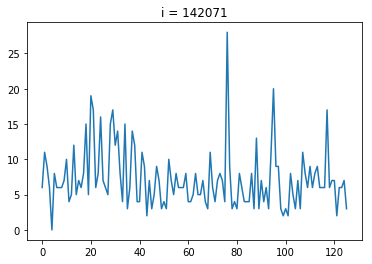

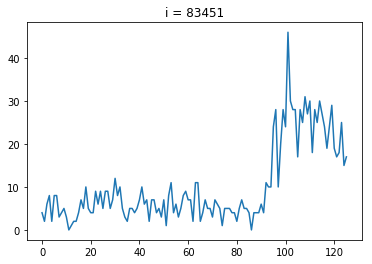

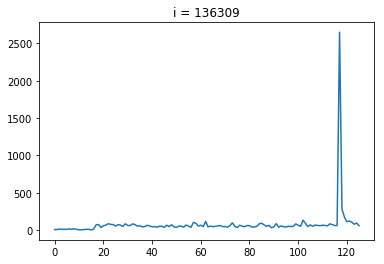

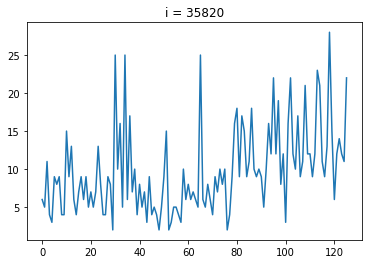

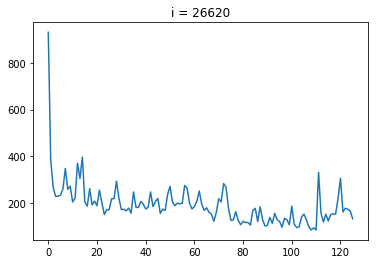

array([142071,  83451, 136309,  35820,  26620])

In [32]:
examine(input_data)

## Transform Data

### Log

In [33]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [80]:
input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

##### Check Log transformation

In [81]:
output_data_log.shape, output_data.shape

((145063, 126), (145063, 126))

In [82]:
input_data_log.shape, input_data.shape

((145063, 126), (145063, 126))

In [83]:
input_data_log

array([[ 1.        ,  1.04139269,  1.        , ...,  1.2787536 ,
         1.        ,  1.23044892],
       [ 1.36172784,  1.07918125,  1.91381385, ...,  1.        ,
         0.90308999,  1.20411998],
       [ 0.30103   ,  0.60205999,  0.69897   , ...,  0.47712125,
         0.47712125,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [84]:
output_data_log

array([[ 1.2787536 ,  1.43136376,  0.95424251, ...,  1.30103   ,
         1.2787536 ,  1.32221929],
       [ 1.41497335,  1.36172784,  2.161368  , ...,  1.66275783,
         1.43136376,  1.32221929],
       [ 0.60205999,  0.77815125,  0.69897   , ...,  0.60205999,
         0.69897   ,  1.25527251],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
# Check inverse log transformation
input_data_log_tt = unlog(input_data_log)
input_data_log_tt_dif = input_data_log_tt - input_data_num
input_data_log_tt_dif.min(), input_data_log_tt_dif.max()

(-1.862645149230957e-08, 1.862645149230957e-08)

In [39]:
# Check inverse log transformation
output_data_log_tt = unlog(output_data_log)
output_data_log_tt_dif = output_data_log_tt - output_data_num
output_data_log_tt_dif.min(), output_data_log_tt_dif.max()

(-2.9802322387695313e-08, 2.6077032089233398e-08)

### Normalization (Shift and Scale)

#### Compute Median and Stdev

In [41]:
input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_center  # remember sample-wised center

array([[ 1.04139269],
       [ 1.23044892],
       [ 0.60205999],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [42]:
input_scale = np.nanstd(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
input_scale[input_scale == 0.0] = 1.0  # Prevent divid by zero
input_scale  # remember sample-wised scale

array([[ 0.22974401],
       [ 0.23685744],
       [ 0.27363311],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

In [43]:
output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_center  # remember sample-wised center

array([[ 1.2787536 ],
       [ 1.44715803],
       [ 0.69897   ],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [44]:
output_scale = np.nanstd(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
output_scale[output_scale == 0.0] = 1.0  # Prevent divid by zero
output_scale  # remember sample-wised scale

array([[ 0.19725496],
       [ 0.25052371],
       [ 0.21878369],
       ..., 
       [ 1.        ],
       [ 1.        ],
       [ 1.        ]])

##### Check zero in scale

In [53]:
# Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

array([], dtype=float64)

In [85]:
# Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

array([], dtype=float64)

#### Transform by Median and Stdev

In [46]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [47]:
# Normalize the input_data and output_data
input_data_norm = transform(input_data_log, input_center, input_scale)
output_data_norm = transform(output_data_log, output_center, output_scale)

##### Check median and stdev transformations

In [48]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [49]:
check_nan(input_data_norm), check_nan(output_data_norm)  # Check if there is any nan in the input_data

([], [])

In [50]:
# Check inverse scale transformation
input_data_norm_it = untransform(input_data_norm, input_center, input_scale)
input_data_norm_it_dif = input_data_norm_it - input_data_log
input_data_norm_it_dif.min(), input_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

In [51]:
# Check inverse scale transformation
output_data_norm_it = untransform(output_data_norm, output_center, output_scale)
output_data_norm_it_dif = output_data_norm_it - output_data_log
output_data_norm_it_dif.min(), output_data_norm_it_dif.max()

(-8.8817841970012523e-16, 8.8817841970012523e-16)

## Scale Investigation

#### Input median

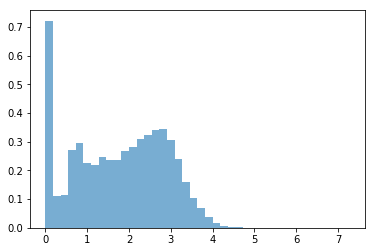

In [61]:
plt.hist(input_center, bins=40, normed=True, alpha=0.6)
plt.show()

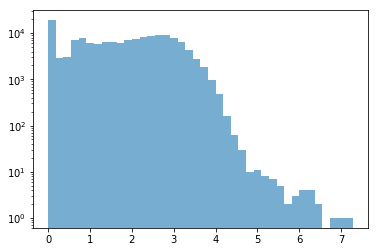

In [62]:
plt.hist(input_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output median

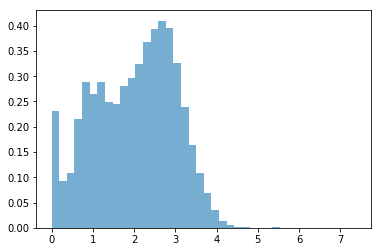

In [63]:
plt.hist(output_center, bins=40, normed=True, alpha=0.6)
plt.show()

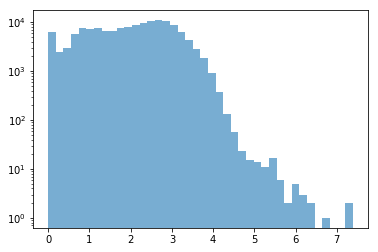

In [64]:
plt.hist(output_center, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Input std

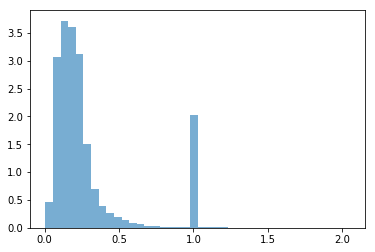

In [58]:
plt.hist(input_scale, bins=40, normed=True, alpha=0.6)
plt.show()

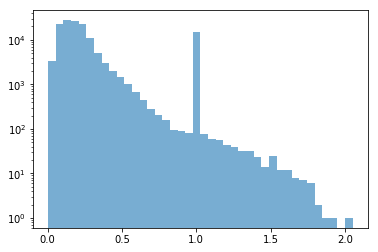

In [57]:
plt.hist(input_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

#### Output std

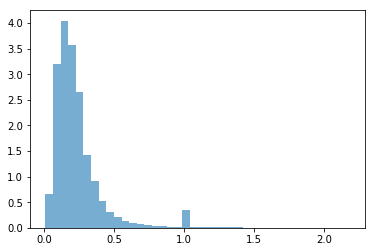

In [59]:
plt.hist(output_scale, bins=40, normed=True, alpha=0.6)
plt.show()

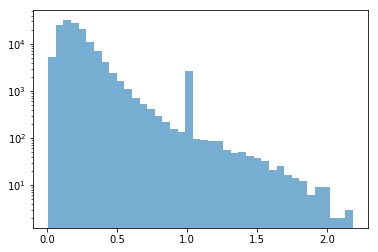

In [60]:
plt.hist(output_scale, bins=40, alpha=0.6)
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [116]:
def group_index(logx):
    if logx == 0.: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    elif logx < 5.0: return 3
    else: return 4
group_index_v = np.vectorize(group_index)
gp_list = list(range(5)); gp_list

[0, 1, 2, 3, 4]

In [119]:
input_gp = group_index_v(input_center).reshape(-1); input_gp

array([1, 1, 1, ..., 0, 0, 0])

In [120]:
output_gp = group_index_v(output_center).reshape(-1); output_gp

array([1, 1, 1, ..., 0, 0, 0])

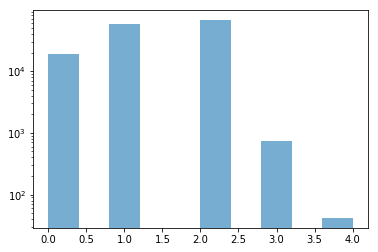

In [121]:
plt.hist(input_gp, alpha=0.6)
plt.yscale('log')
plt.show()

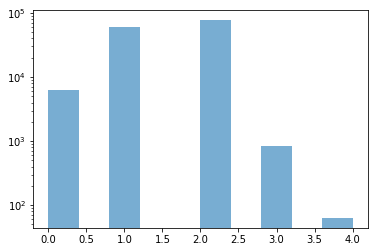

In [122]:
plt.hist(output_gp, alpha=0.6)
plt.yscale('log')
plt.show()

## Make (X,Y) pairs data from data set

day_shift = 0

def make_XY(data, x_length=x_length, y_length=y_length, shift=day_shift):
    if shift == 0:
        return data[:, -x_length-y_length:-y_length], data[:, -y_length:]
    else:
        return data[:, -x_length-y_length-shift:-y_length-shift], data[:, -y_length-shift:-shift]

In [65]:
X_input = input_data_norm[:, :x_length]
Y_input = input_data_norm[:, -y_length:]
X_input.shape, Y_input.shape

((145063, 63), (145063, 63))

In [68]:
X_output = output_data_norm[:, :x_length]
Y_output = output_data_norm[:, -y_length:]
X_output.shape, Y_output.shape

((145063, 63), (145063, 63))

#### Original data

In [94]:
X_input_ori = input_data_num[:, :x_length]
Y_input_ori = input_data_num[:, -y_length:]
X_output_ori = output_data_num[:, :x_length]
Y_output_ori = output_data_num[:, -y_length:]

#### Backward compatible

In [87]:
X_train = X_input
Y_train = Y_input

In [90]:
X_val = X_output
Y_val = Y_output

In [95]:
X_train_ori = X_input_ori
Y_train_ori = Y_input_ori
X_val_ori = X_output_ori
Y_val_ori = Y_output_ori

In [104]:
train_scale = input_scale
train_center = input_center
val_scale = output_scale
val_center = output_scale

#### Check

X_input, input_data_norm[:,:x_length]

Y_input, input_data_norm[:,-y_length:]

X_output, output_data_norm[:,:x_length]

Y_output, output_data_norm[:,-y_length:]

X_input_ori, input_data_num

Y_input_ori, input_data_num

X_output_ori, output_data_num

Y_output_ori, output_data_num

In [102]:
arr_info((X_input, Y_input, X_output, Y_output, 
          X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))

(145063, 63) -7.56988545755 8.00100800101 0.0 0.968286226274
(145063, 63) -49.0306290766 105.67918878 0.0 1.8412771035
(145063, 63) -7.92981290925 8.00100800101 0.0 1.00961331391
(145063, 63) -57.6311852404 121.197360262 0.0 2.08074661026
(145063, 63) 0.0 21553554.0 75.0 64150.7195046
(145063, 63) 0.0 21366420.0 88.0 62373.0578871
(145063, 63) 0.0 33446984.0 139.0 87516.7023757
(145063, 63) 0.0 28342885.0 143.0 81329.6278471


### Split Data into Training and (Pseudo) Cross Validation Sets
Not using this. Use keras built-in feature for pseudo validation

def make_shuffle_index(n, seed=None):
    shuffle_index = np.array(list(range(n)))
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

def using(array_ori, index_list):
    #return np.array([array_ori[i] for i in index_list])
    return np.take(array_ori, index_list, axis=0)

#Generate a shuffle list
shuffle_index = make_shuffle_index(len(X_input), seed=123)

Keep 10% of input data as validation set

#Split the index list into training and validation sets
n_val = int(len(X_input) * 0.1)
val_index = shuffle_index[:n_val]
train_index = shuffle_index[n_val:]

#Split the data sets according to the index list
X_train = using(X_input, train_index)
Y_train = using(Y_input, train_index)
X_val = using(X_input, val_index)
Y_val = using(Y_input, val_index)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

#### Split the untransformed data
Split the untransformed data in the same way for score estimation

train_data_num = using(input_data_num, train_index)
val_data_num = using(input_data_num, val_index)

X_train_ori, Y_train_ori = make_XY(train_data_num)
X_val_ori, Y_val_ori = make_XY(val_data_num)
X_train_ori.shape, Y_train_ori.shape, X_val_ori.shape, Y_val_ori.shape

train_center = using(input_center, train_index)
val_center = using(input_center, val_index)
train_scale = using(input_scale, train_index)
val_scale = using(input_scale, val_index)
train_center.shape, val_center.shape, train_scale.shape, val_scale.shape

#### Check if the inverse transformation is correct

#Undo transformation
X_train_tt = unlog(untransform(X_train, train_center, train_scale))

X_train_tt_diff = X_train_tt - X_train_ori
X_train_tt_diff.min(), X_train_tt_diff.max()

## Split X,Y data into groups

In [126]:
X_input[input_gp == gp].shape

(42, 63)

In [129]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]

In [130]:
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Neural Network?

In [86]:
from keras.models import Sequential
#from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [88]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(),
                                            None))
    return 200. * K.mean(diff, axis=-1)

In [89]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), K.epsilon(),
                          None))
    return 200. * np.mean(diff, axis=axis)

In [91]:
# Benchmark SMAPE on the transformed data
smape(Y_train,X_train), smape(Y_val,X_val), smape(Y_train,Y_train)

(129.60436607794315, 141.08179051578969, 0.0)

In [103]:
# Benchmark SMAPE on the original data
smape(Y_train_ori,X_train_ori), smape(Y_val_ori,X_val_ori), \
smape(Y_train_ori,Y_train_ori)

(51.874930937113326, 57.677220315844565, 0.0)

Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [105]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Reshape

In [262]:
models = []
for gp in gp_list:
    print('Group:', gp)
    layer_0 = Input(shape=(x_length,))
    layer_t = Reshape((-1, 1))(layer_0)
    layer_t = Conv1D(60, kernel_size=7, activation='relu')(layer_t)
    layer_t = Flatten()(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.25)(layer_t)
    layer_t = Dense(120, activation='relu')(layer_t)
    layer_t = Dropout(0.5)(layer_t)
    layer_f = Dense(y_length)(layer_t)
    model = Model(inputs=layer_0, outputs=layer_f)
    model.compile(optimizer='adam',
                  loss='mean_squared_error', metrics=[k_smape])
    model.summary()
    models.append(model)

Group: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 63)                0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 63, 1)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 57, 60)            480       
_________________________________________________________________
flatten_7 (Flatten)          (None, 3420)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               410520    
_________________________________________________________________
dropout_13 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 120)               14520     
_

About 22s for 1 epoch on i5-750 CPU

In [263]:
epochs_list = [20,40,20,80,80]

In [ ]:
hists = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists.append(hist)

Train on 18086 samples, validate on 952 samples
Epoch 1/20
18086/18086 [==============================] - 4s - loss: 4.4151 - k_smape: 183.9397 - val_loss: 5.3130 - val_k_smape: 184.0381
Epoch 2/20
18086/18086 [==============================] - 3s - loss: 4.0498 - k_smape: 182.8830 - val_loss: 5.3344 - val_k_smape: 183.7590
Epoch 3/20
18086/18086 [==============================] - 3s - loss: 3.8496 - k_smape: 183.0652 - val_loss: 5.6942 - val_k_smape: 185.0957
Epoch 4/20
18086/18086 [==============================] - 3s - loss: 3.8097 - k_smape: 183.1189 - val_loss: 5.6668 - val_k_smape: 183.9832
Epoch 5/20
18086/18086 [==============================] - 3s - loss: 3.5433 - k_smape: 182.8419 - val_loss: 5.9452 - val_k_smape: 184.7275
Epoch 6/20
18086/18086 [==============================] - 3s - loss: 3.6397 - k_smape: 183.0542 - val_loss: 5.6321 - val_k_smape: 184.6008
Epoch 7/20
18086/18086 [==============================] - 3s - loss: 3.4890 - k_smape: 182.8425 - val_loss: 5.6856 - v

### Training History

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title('Mean Squared Error - ' + str(gp))
    plt.legend(); plt.show()

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label='train')
    plt.plot(hist.history['val_k_smape'], label='validation')
    plt.title('SMAPE - ' + str(gp))
    plt.legend(); plt.show()

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

In [ ]:
for (hist, gp) in zip(hists, gp_list):
    plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

hist2 = model.fit(X_train, Y_train, batch_size=128, epochs=5, 
                 validation_data=(X_val, Y_val))

model.evaluate(X_val,Y_val)

plt.plot(hist2.history['loss'], label='train')
plt.plot(hist2.history['val_loss'], label='validation')
plt.title('Mean Squared Error')
plt.legend(); plt.show()

plt.plot(hist2.history['k_smape'], label='train')
plt.plot(hist2.history['val_k_smape'], label='validation')
plt.title('SMAPE')
plt.legend(); plt.show()

### Predict for Validation set

Y_val_pred = model.predict(X_val)

examine(Y_val_pred)

Y_val_pred_ori = unlog(untransform(Y_val_pred, val_center, val_scale))

#SMAPE of the validation set
smape(Y_val_ori, Y_val_pred_ori)

def view_val(i):
    plt.plot(Y_val_pred_ori[i])
    plt.plot(Y_val_ori[i])
    plt.plot(X_val_ori[i])
    plt.show()

view_val(10)

### Evaluation using for Output Set

In [245]:
for (gp, model, X, Y) in zip(gp_list, models, 
                             X_output_list, Y_output_list):
    print()
    print(model.evaluate(X,Y))


5696/6191 [==========================>...] - ETA: 0s[18.774312929765529, 164.37638385213842]

60576/60859 [============================>.] - ETA: 0s[2.6044021717974233, 150.40939227129746]

76512/77113 [============================>.] - ETA: 0s[3.6608085605209064, 127.18425458935018]

768/837 [==========================>...] - ETA: 0s[3.4383163554694063, 122.67989620085686]

32/63 [==============>...............] - ETA: 0s[15.933907001737564, 133.72339339483352]


### Predict for Output Set

In [246]:
Y_output_pred_list = []
for (gp, model, X) in zip(gp_list, models, X_output_list):
    print(gp)
    Y_output_pred_list.append(model.predict(X))

0
1
2
3
4


Find the original index

In [247]:
len(output_gp)

145063

In [248]:
output_index_range = np.arange(len(output_gp)); output_index_range

array([     0,      1,      2, ..., 145060, 145061, 145062])

In [249]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [250]:
for o in output_index_list:
    print(o.shape)

(6191,)
(60859,)
(77113,)
(837,)
(63,)


In [251]:
output_index_list_comb = np.concatenate(output_index_list)

In [252]:
output_index_list_comb

array([    52,     54,     55, ..., 131296, 139119, 140151])

In [253]:
Y_output_pred_comb = np.concatenate(Y_output_pred_list)

In [254]:
Y_output_pred_temp = [0]*len(output_index_list_comb)
for index, y in zip(output_index_list_comb, Y_output_pred_comb):
    Y_output_pred_temp[index] = y
Y_output_pred = np.array(Y_output_pred_temp)

In [255]:
Y_output_pred

array([[-0.11980961, -0.12358002, -0.03558843, ...,  0.03372262,
         0.07472475,  0.31082979],
       [ 0.09458057,  0.08669119,  0.18121451, ...,  0.28442028,
         0.36418247,  0.59301221],
       [-0.09632482, -0.07303151,  0.00367343, ..., -0.07928965,
        -0.0182111 ,  0.21918713],
       ..., 
       [ 0.04947104,  0.03259677,  0.08284719, ...,  0.28351516,
         0.28641596,  0.32293811],
       [ 0.04947104,  0.03259677,  0.08284719, ...,  0.28351516,
         0.28641596,  0.32293811],
       [ 0.04947104,  0.03259677,  0.08284719, ...,  0.28351516,
         0.28641596,  0.32293811]], dtype=float32)

Y_output_pred_list[1]

output_index_list_comb[0]

Y_output_pred[52]

Y_output_pred_list[0]

In [256]:
Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                      output_center, output_scale))

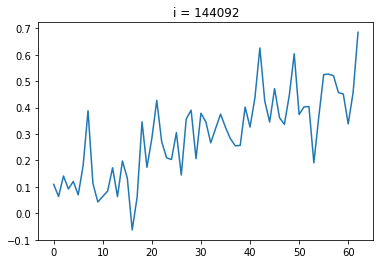

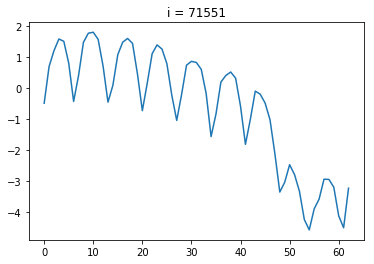

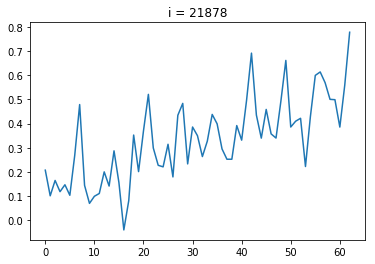

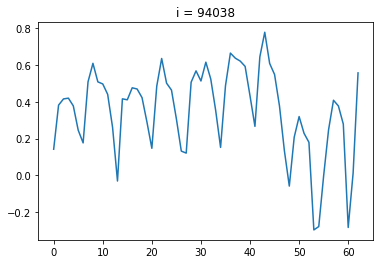

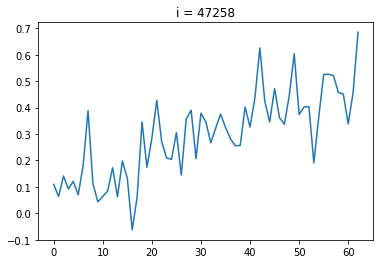

array([144092,  71551,  21878,  94038,  47258])

In [257]:
examine(Y_output_pred)

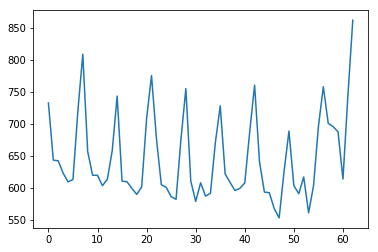

In [258]:
view(Y_output_pred_ori[28450])

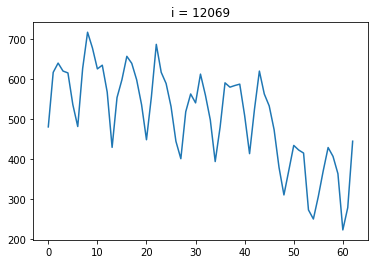

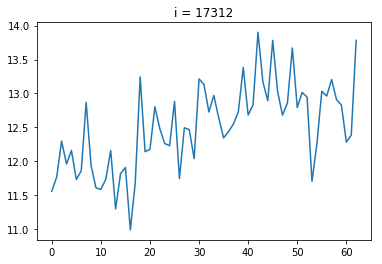

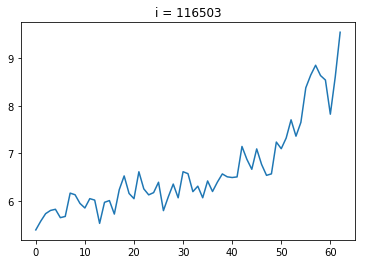

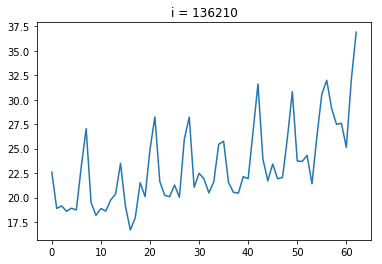

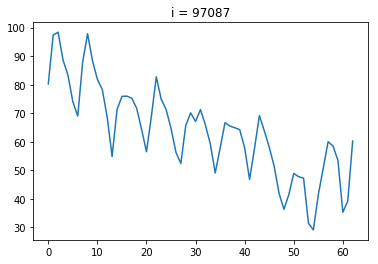

array([ 12069,  17312, 116503, 136210,  97087])

In [259]:
examine(Y_output_pred_ori)

## Test

Y_output_ori = output_data_num[:,-y_length:]

In [260]:
# SMAPE of the real test set
smape(Y_output_ori, Y_output_pred_ori)

50.265279785056251

SMAPE:

50.523 - Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

- Model 6.0.1 CNN - Conv(60, 3)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches

50.686 - Model 6.3.0 CNN - 

50.265

## Output

print('%%% Reading data key_1.csv ...', end = '', flush = True)
output_df = pd.read_csv("../data/key_1.csv")
print('done!')

output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df

output_df.info()

output_df['date'].values[0:62]  # Make sure the range is 60 days (see if the dates resume after 60)

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

result_df = pd.DataFrame(Y_output_pred_ori, columns = predict_dates_index)
result_df

result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')
result_flat_df

output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_1_' + model_name
                                + '.csv', index = False)
print('done!')

Kaggle Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

## Compare

Y_input_ori = input_data[:,-y_length:]
X_input_ori = input_data[:,:x_length]
X_output_ori = output_data[:,:x_length]

In [229]:
def comp_view(x1, x2, title=None, show=True):
    plt.plot(x1)
    plt.plot(x2)
    if title: plt.title(title)
    if show: plt.show()

def comp_examine(data1, data2, view_n=10, view_list=None):
    n_data = len(data1)
    if not data1.shape == data2.shape: print(data1.shape, data2.shape, 'not the same length')
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        comp_view(data1[i], data2[i], title='i = ' + str(i))
    return list(view_list)

def multi_view(x_list, title=None, show=True):
    for x in x_list:
        plt.plot(x)
    if title: plt.title(title)
    if show: plt.show()

def examine_list(data_list, view_n=10, view_list=None):
    n_data = len(data_list[0])
    if not view_list: view_list = np.random.choice(n_data, min(view_n, n_data), replace=False)
    for i in view_list:
        multi_view([data[i] for data in data_list], 
                   title='i = ' + str(i))
    return list(view_list)

view_list = None

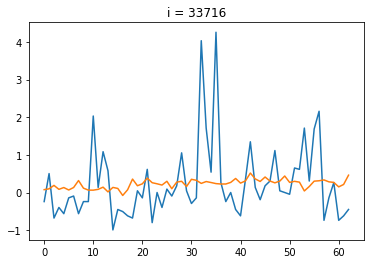

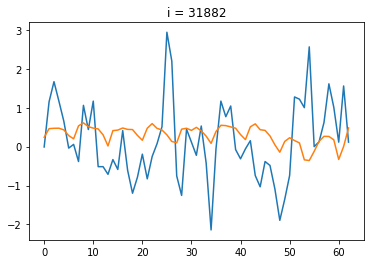

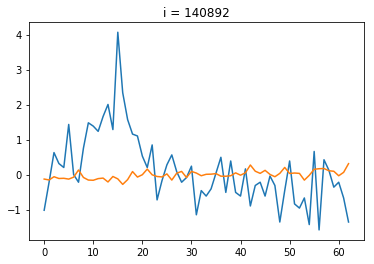

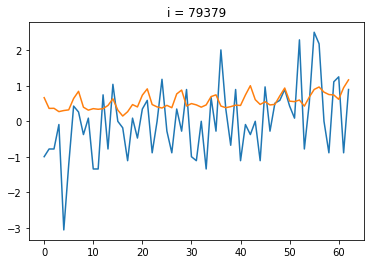

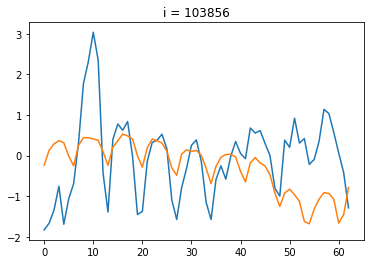

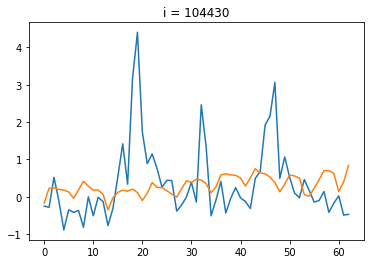

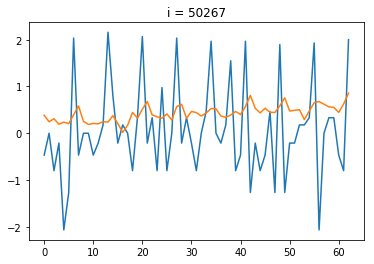

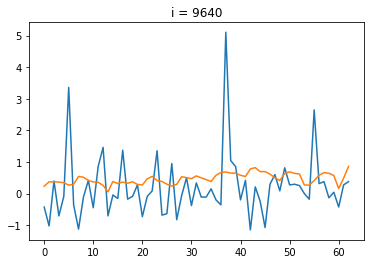

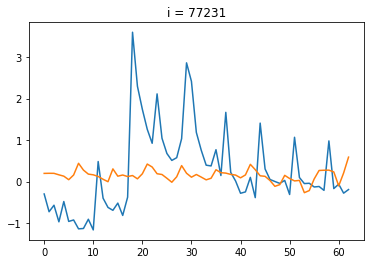

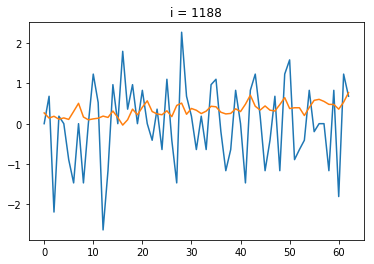

In [230]:
view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

In [231]:
view_list

[33716, 31882, 140892, 79379, 103856, 104430, 50267, 9640, 77231, 1188]

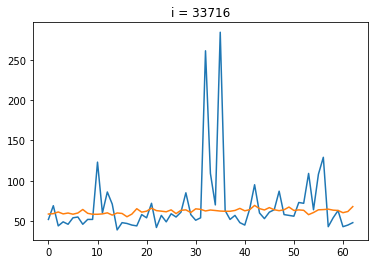

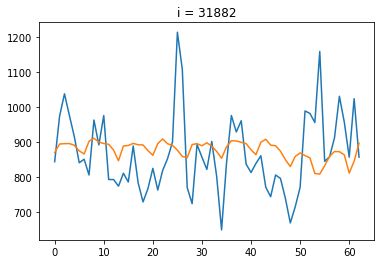

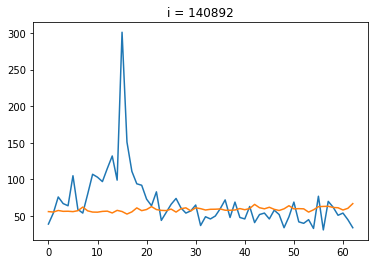

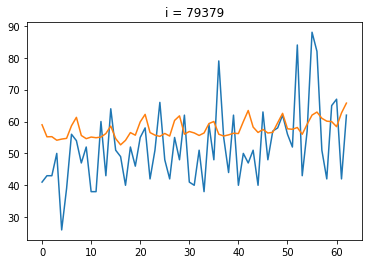

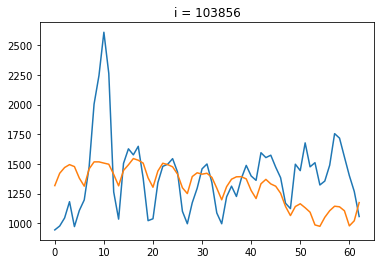

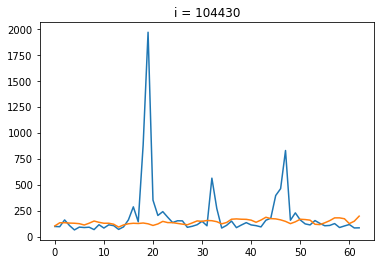

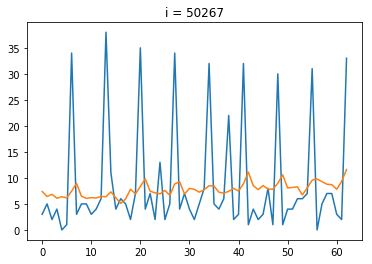

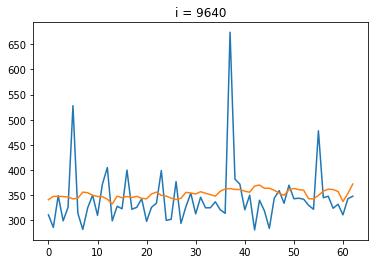

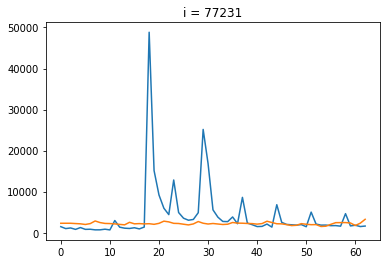

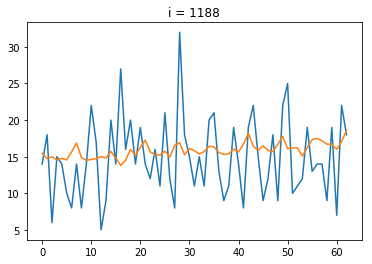

In [232]:
view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

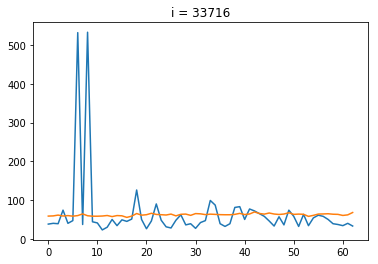

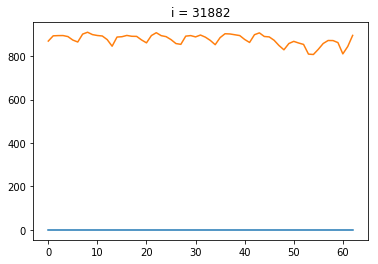

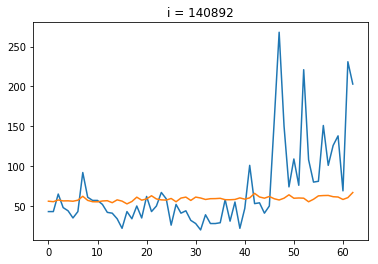

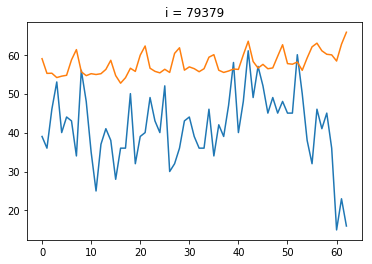

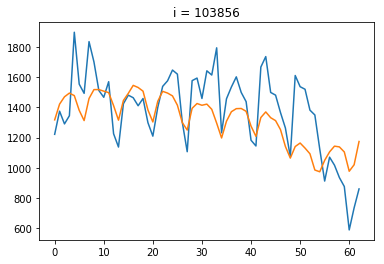

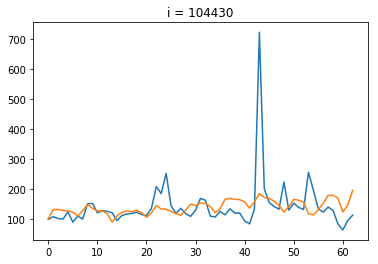

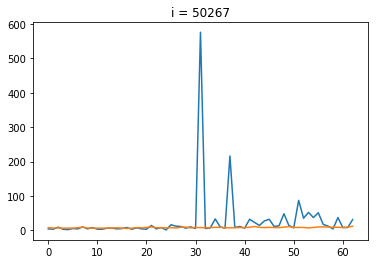

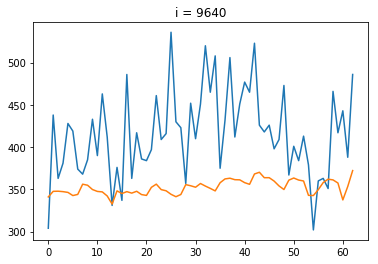

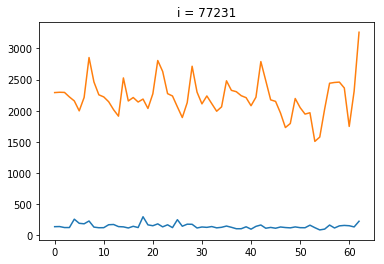

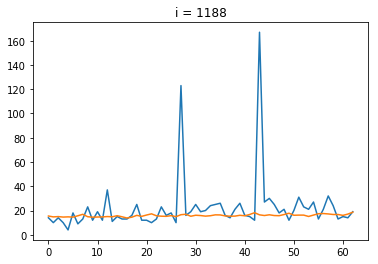

In [233]:
view_list = comp_examine(Y_input_ori, Y_output_pred_ori, view_list=view_list)

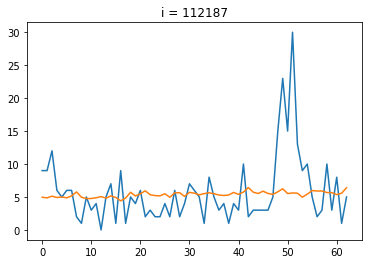

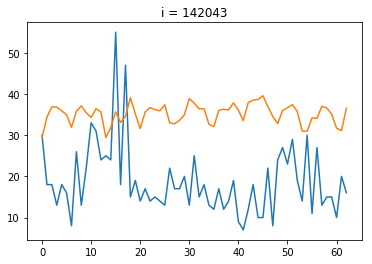

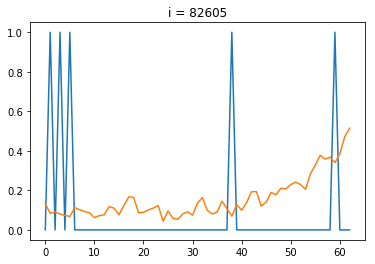

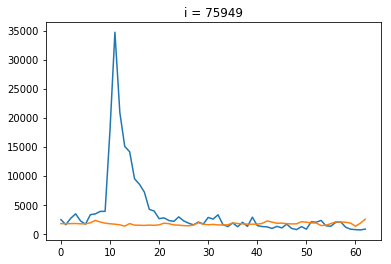

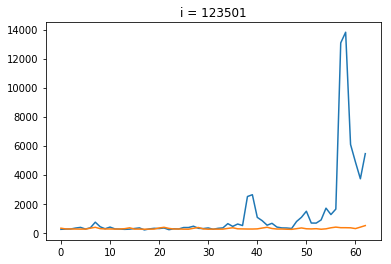

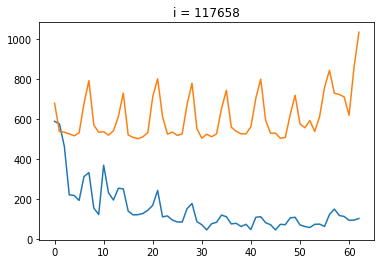

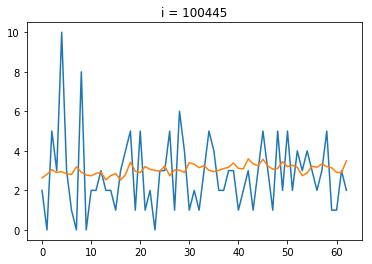

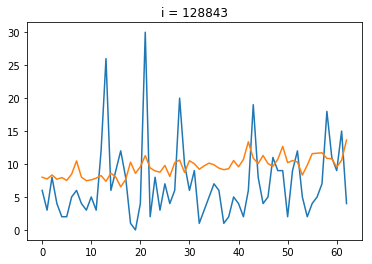

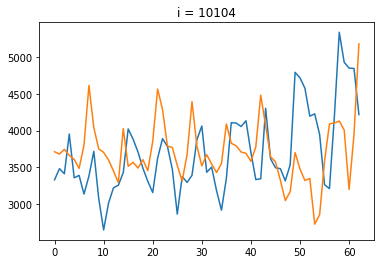

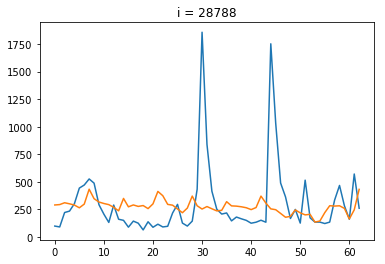

In [221]:
view_list = comp_examine(Y_output_ori, Y_output_pred_ori, view_list=view_list)

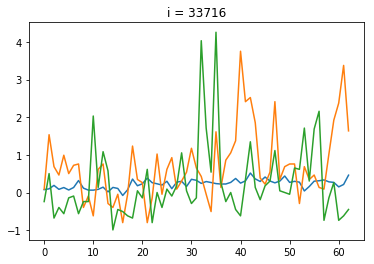

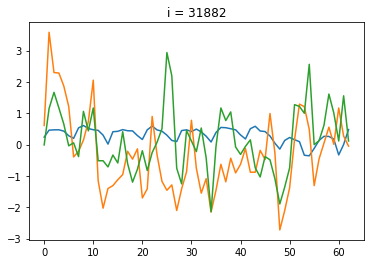

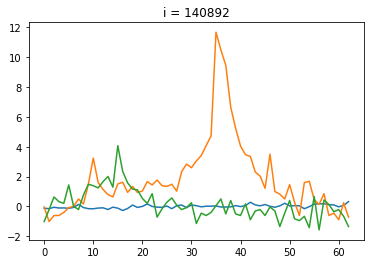

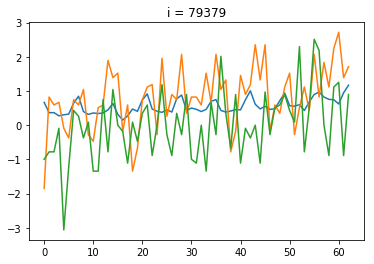

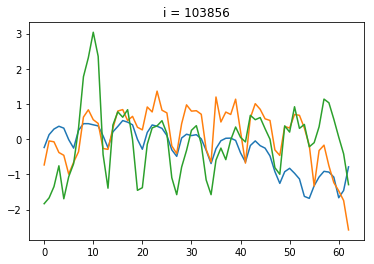

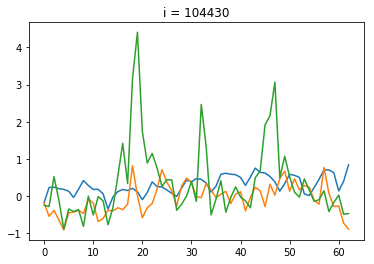

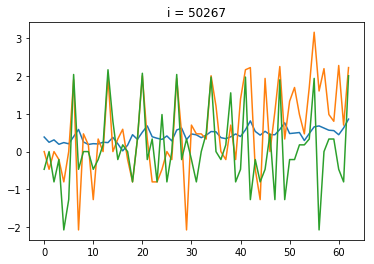

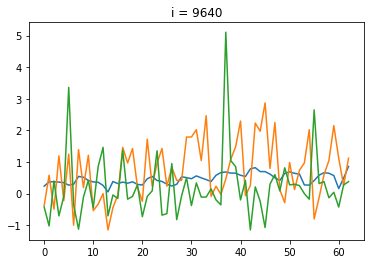

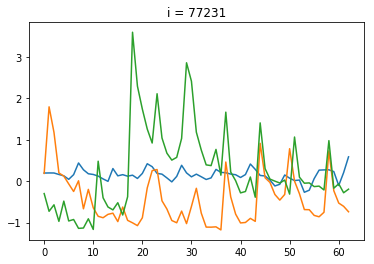

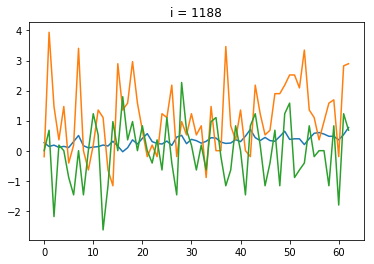

In [234]:
view_list = examine_list((Y_output_pred, Y_output, X_output), 
                         view_list=view_list)

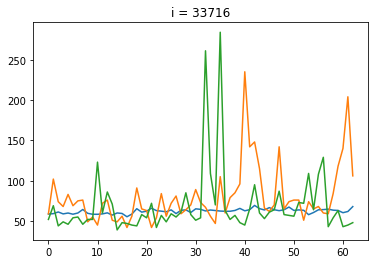

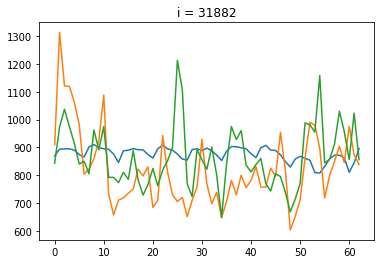

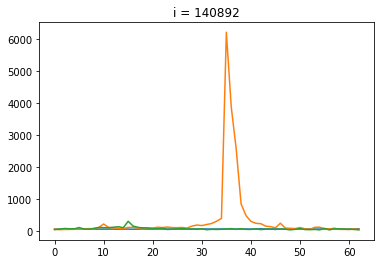

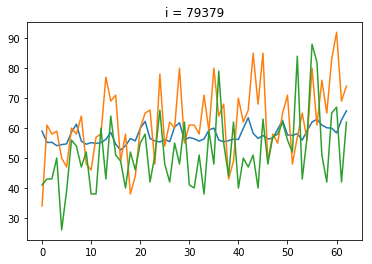

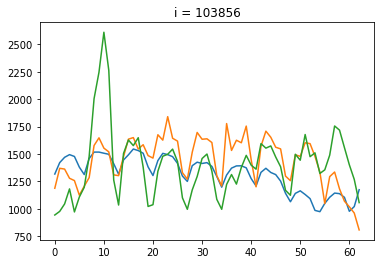

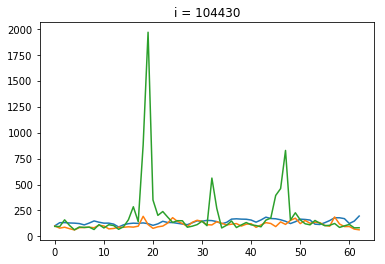

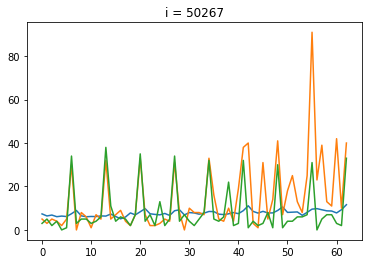

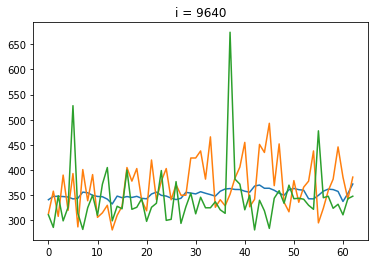

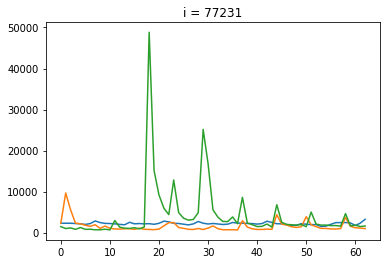

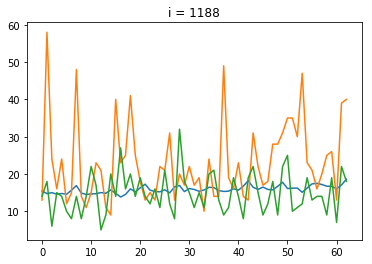

In [235]:
view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), 
                         view_list=view_list)

In [236]:
output_gp[50267]

1

In [208]:
input_df.iloc[:,-63*2:-63].values

array([[  18.,   26.,    8., ...,   20.,   12.,   19.],
       [  25.,   22.,  144., ...,   21.,   27.,   33.],
       [   3.,    5.,    4., ...,    3.,    3.,    2.],
       ..., 
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

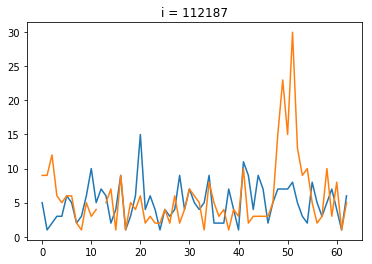

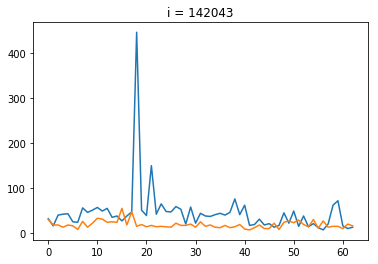

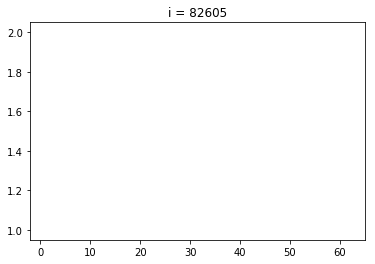

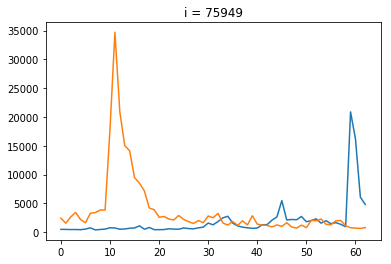

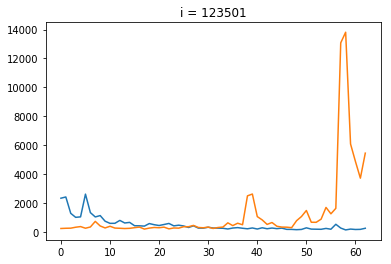

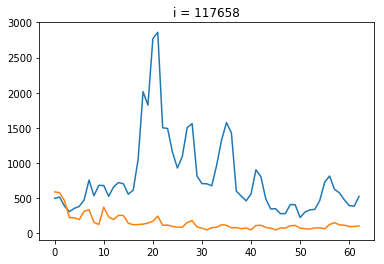

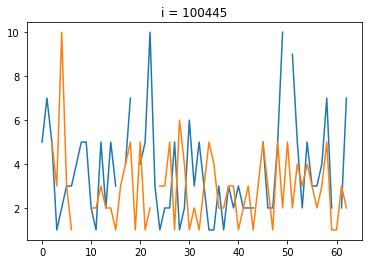

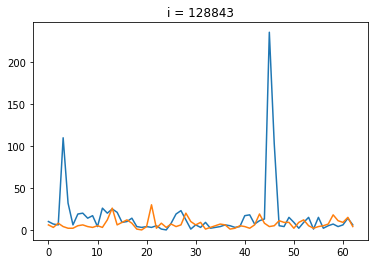

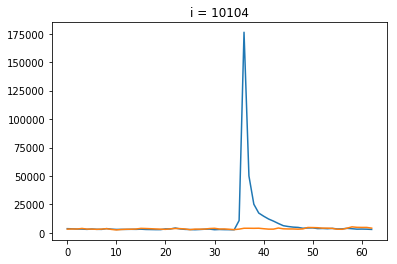

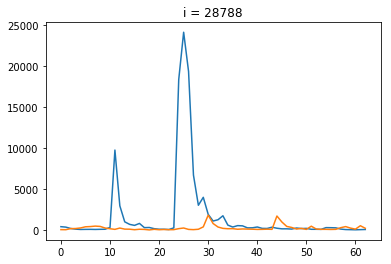

[112187, 142043, 82605, 75949, 123501, 117658, 100445, 128843, 10104, 28788]

In [222]:
comp_examine(input_df.iloc[:,-63*2:-63].values,input_df.iloc[:,-63:].values, view_list=view_list)

#### Case 143557

In [210]:
i = 143557

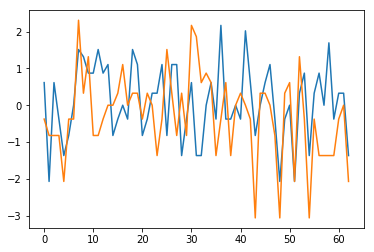

In [211]:
comp_view(X_input[i], Y_input[i])

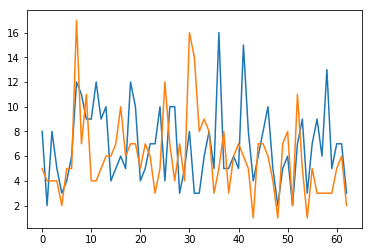

In [212]:
comp_view(X_input_ori[i], Y_input_ori[i])

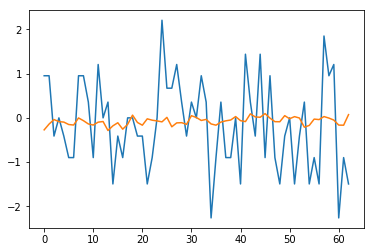

In [213]:
comp_view(X_output[i], Y_output_pred[i])

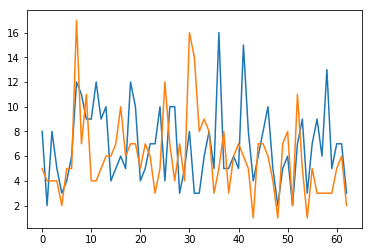

In [214]:
comp_view(X_input_ori[i], Y_input_ori[i])

In [215]:
input_center[i], output_center[i], input_scale[i], output_scale[i]

(array([ 0.84509804]),
 array([ 0.84509804]),
 array([ 0.17770392]),
 array([ 0.16257146]))